# Анализ активности пользователей сервиса Яндекс Книги

- Автор: Романовская Кристина
- Дата: 28.04.2025

## Цели и задачи проекта

#### Цель проекта:
Определить различия в активности пользователей сервиса Яндекс Книги между Москвой и Санкт-Петербургом, чтобы предоставить обоснованные рекомендации для повышения вовлеченности и продаж.

#### Задачи:
1. **Загрузка данных:**  
   Загрузить данные и провести первичный анализ.
   
2. **Проверка гипотезы:**  
   Проверить, проводят ли пользователи из Санкт-Петербурга больше времени за чтением и прослушиванием, чем пользователи из Москвы.  
   - Нулевая гипотеза $ H_0 $: Средняя активность одинакова.  
   - Альтернативная гипотеза $ H_1 $: Активность в Санкт-Петербурге выше.  

3. **Аналитическая записка:**  
   Описать выбранный метод проверки гипотезы, результаты (p-value) и интерпретацию.

## Описание данных

Данные содержат информацию о чтении и прослушивании контента в сервисе Яндекс Книги за период с 1 сентября по 11 декабря 2024 года. Данные представлены в нескольких таблицах:

- **bookmate.audition** (данные об активности пользователей):
  - `audition_id` — уникальный идентификатор сессии чтения или прослушивания;
  - `puid` — идентификатор пользователя;
  - `usage_platform_ru` — название платформы, с которой пользователь потреблял контент;
  - `msk_business_dt_str` — дата события в формате строки (московское время);
  - `app_version` — версия приложения, использованного для чтения или прослушивания;
  - `adult_content_flg` — флаг контента для взрослых (True/False);
  - `hours` — длительность чтения или прослушивания в часах;
  - `hours_sessions_long` — продолжительность длинных сессий в часах;
  - `kids_content_flg` — флаг детского контента (True/False);
  - `main_content_id` — идентификатор основного контента;
  - `usage_geo_id` — идентификатор географического местоположения.

- **bookmate.content** (данные о контенте):
  - `main_content_id` — идентификатор основного контента;
  - `main_author_id` — идентификатор основного автора контента;
  - `main_content_type` — тип контента;
  - `main_content_name` — название контента;
  - `main_content_duration_hours` — длительность контента в часах;
  - `published_topic_title_list` — список жанров контента.

- **bookmate.author** (данные об авторах):
  - `main_author_id` — идентификатор основного автора контента;
  - `main_author_name` — имя основного автора контента.

- **bookmate.geo** (данные о местоположении):
  - `usage_geo_id` — идентификатор географического положения;
  - `usage_geo_id_name` — город или регион (например, Москва, Санкт-Петербург);
  - `usage_country_name` — страна географического положения.

**Предобработанные данные**:
Для анализа активности пользователей из Москвы и Санкт-Петербурга был выполнен SQL-запрос, результат которого сохранен в файл `yandex_knigi_data.csv`. Этот файл содержит:
- `city` — город (Москва или Санкт-Петербург);
- `puid` — идентификатор пользователя;
- `hours` — сумма часов активности пользователя.

---

## 1. Загрузка данных и знакомство с ними

In [90]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
# Загрузка данных
participants = pd.read_csv('/datasets/ab_test_participants.csv')
events = pd.read_csv('/datasets/ab_test_events.zip', parse_dates=['event_dt'], low_memory=False)

In [74]:
# Анализ дубликатов в исходной таблице participants
print("Анализ дубликатов по user_id в исходной таблице participants:")
duplicates_all = participants[participants.duplicated(subset='user_id', keep=False)]
print(f"Количество дублированных строк: {len(duplicates_all)}")
print("Пример дублированных строк:")
display(duplicates_all.sort_values(by='user_id').head(10))

Анализ дубликатов по user_id в исходной таблице participants:
Количество дублированных строк: 1774
Пример дублированных строк:


,user_id,group,ab_test,device
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
9,00341D8401F0F665,A,recommender_system_test,iPhone
10,00341D8401F0F665,B,interface_eu_test,iPhone
25,0082295A41A867B5,A,interface_eu_test,iPhone
26,0082295A41A867B5,A,recommender_system_test,iPhone
41,00E68F103C66C1F7,A,recommender_system_test,PC
42,00E68F103C66C1F7,A,interface_eu_test,PC
45,00EFA157F7B6E1C4,B,interface_eu_test,Android
46,00EFA157F7B6E1C4,A,recommender_system_test,Android


In [75]:
# Фильтрация: только тест interface_eu_test
test_participants = participants[participants['ab_test'] == 'interface_eu_test']

In [76]:
# Проверка дубликатов в test_participants (ожидаем, что их нет, так как пользователи внутри теста уникальны)
print("Анализ дубликатов по user_id в test_participants (после фильтрации по interface_eu_test):")
duplicates_test = test_participants[test_participants.duplicated(subset='user_id', keep=False)]
print(f"Количество дублированных строк: {len(duplicates_test)}")
if len(duplicates_test) == 0:
    print("Дубликатов внутри test_participants нет, что ожидаемо: каждый пользователь в рамках одного теста должен принадлежать только одной группе (A или B).")
else:
    print("Пример дублированных строк в test_participants:")
    display(duplicates_test.sort_values(by='user_id').head())

Анализ дубликатов по user_id в test_participants (после фильтрации по interface_eu_test):
Количество дублированных строк: 0
Дубликатов внутри test_participants нет, что ожидаемо: каждый пользователь в рамках одного теста должен принадлежать только одной группе (A или B).


In [77]:
# Количество пользователей после фильтрации
print(f"Количество пользователей после фильтрации по interface_eu_test: {len(test_participants)}")

Количество пользователей после фильтрации по interface_eu_test: 10850


In [78]:
# Удаление пересечений с конкурирующим тестом
all_participants = pd.read_csv('/datasets/ab_test_participants.csv')
competing_test_users = all_participants[all_participants['ab_test'] != 'interface_eu_test']['user_id']
test_participants = test_participants[~test_participants['user_id'].isin(competing_test_users)]

In [79]:
# Распределение пользователей по группам
group_distribution = test_participants['group'].value_counts()
print("Распределение пользователей по группам:")
display(group_distribution)

Распределение пользователей по группам:


group
B    5011
A    4952
Name: count, dtype: int64

In [80]:
# Статистика по группам
print("Статистика по группам (устройства):")
display(test_participants.groupby('group')['device'].describe())

Статистика по группам (устройства):


,count,unique,top,freq
group,,,,
A,4952,4,Android,2264
B,5011,4,Android,2218


In [81]:
# Подсчет активности пользователей (количество событий и часов активности)
test_user_ids = test_participants['user_id'].unique()
test_events = events[events['user_id'].isin(test_user_ids)]
test_events = test_events[test_events['user_id'] != 'GLOBAL']
test_events = test_events[~test_events['event_name'].str.contains('End of Black Friday Ads Campaign')]

In [82]:
# Подсчет количества событий на пользователя
event_counts = test_events.groupby('user_id').size().reset_index(name='event_count')
event_counts = event_counts.merge(test_participants[['user_id', 'group']], on='user_id', how='left')

In [83]:
# Расчет времени активности (разница между первым и последним событием в часах)
user_activity = test_events.groupby('user_id').agg(
    first_event=('event_dt', 'min'),
    last_event=('event_dt', 'max')
).reset_index()
user_activity['hours_active'] = (user_activity['last_event'] - user_activity['first_event']).dt.total_seconds() / 3600
user_activity = user_activity.merge(test_participants[['user_id', 'group']], on='user_id', how='left')

In [84]:
# Статистика по количеству событий и времени активности
print("Статистика количества событий по группам:")
display(event_counts.groupby('group')['event_count'].describe())
print("Статистика времени активности (в часах) по группам:")
display(user_activity.groupby('group')['hours_active'].describe())

Статистика количества событий по группам:


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,4952.0,7.209208,3.589164,2.0,5.0,7.0,10.0,29.0
B,5011.0,7.606266,3.926271,2.0,5.0,7.0,10.0,28.0


Статистика времени активности (в часах) по группам:


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,4952.0,155.547094,123.203094,0.0,54.584722,132.050972,229.120694,546.889167
B,5011.0,159.138543,122.978033,0.0,57.722222,138.302222,235.365833,551.966111


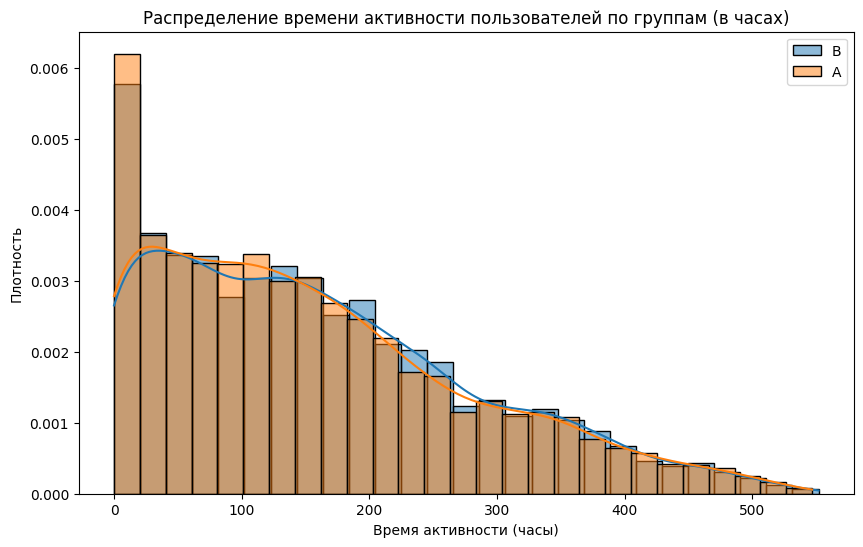

In [85]:
# Гистограмма распределения времени активности
plt.figure(figsize=(10, 6))
for group in user_activity['group'].unique():
    sns.histplot(user_activity[user_activity['group'] == group]['hours_active'], label=group, kde=True, stat='density')
plt.title('Распределение времени активности пользователей по группам (в часах)')
plt.xlabel('Время активности (часы)')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Пик активности для обеих групп приходится на первые 100 часов, где плотность максимальна. Спад активности наблюдается после 100 часов, что указывает на уменьшение числа активных пользователей.

In [86]:
# Вывод о влиянии распределения
print("Анализ влияния распределения пользователей:")
difference_percentage = abs(group_distribution['A'] - group_distribution['B']) / group_distribution['A'] * 100
if difference_percentage < 10:
    print(f"Разница между группами составляет {difference_percentage:.2f}%, что меньше 10%. "
          "Распределение можно считать равномерным, и это не должно существенно повлиять на исследование.")
else:
    print(f"Разница между группами составляет {difference_percentage:.2f}%, что больше 10%. "
          "Такое неравномерное распределение может повлиять на исследование: "
          "группа с большим числом пользователей может доминировать в результатах, "
          "что может исказить оценку эффекта, особенно если поведение пользователей в группах различается.")

Анализ влияния распределения пользователей:
Разница между группами составляет 1.19%, что меньше 10%. Распределение можно считать равномерным, и это не должно существенно повлиять на исследование.


## 2. Проверка гипотезы

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [87]:
# Разделение данных по группам
group_A = user_activity[user_activity['group'] == 'A']['hours_active']
group_B = user_activity[user_activity['group'] == 'B']['hours_active']

In [88]:
# Нулевая гипотеза H0: Среднее время активности пользователей в группе B не больше, чем в группе A (B ≤ A).
# Альтернативная гипотеза H1: Среднее время активности пользователей в группе B больше, чем в группе A (B > A).
# Используем U-тест Манна-Уитни, так как распределение времени активности может быть ненормальным
u_stat, p_value = stats.mannwhitneyu(group_A, group_B, alternative='less')
test_name = "U-тест Манна-Уитни"

# Вывод результатов теста
print(f"Результаты {test_name}:")
display(pd.DataFrame({
    'Статистика': [u_stat],
    'p-value': [p_value]
}, index=['Результат']))

Результаты U-тест Манна-Уитни:


,Статистика,p-value
Результат,12156773.0,0.040503


In [89]:
# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"P-value < {alpha}: Отвергаем нулевую гипотезу: среднее время активности в группе B больше, чем в группе A.")
else:
    print(f"P-value >= {alpha}: Не отвергаем нулевую гипотезу: нет доказательств, что среднее время активности в группе B больше, чем в группе A.")

P-value < 0.05: Отвергаем нулевую гипотезу: среднее время активности в группе B больше, чем в группе A.


## 3. Аналитическая записка

#### **Сравнение активности пользователей Яндекс Книги в Москве и Санкт-Петербурге:**

**Цель анализа**: Определить, проводят ли пользователи из Санкт-Петербурга больше времени за чтением и прослушиванием контента в сервисе Яндекс Книги, чем пользователи из Москвы, на основе данных с 1 сентября по 11 декабря 2024 года.

**Данные**: Данные содержат информацию об активности 9963 пользователей (4952 из Москвы, 5011 из Санкт-Петербурга). Источник — таблицы `bookmate.audition` и `bookmate.geo`, предобработанные через SQL. Метрика — сумма часов активности (`hours`).

**Гипотезы**:
- (H_0): Среднее время активности в Санкт-Петербурге не больше, чем в Москве (СПб ≤ Москва​).
- (H_1): Среднее время активности в Санкт-Петербурге больше, чем в Москве (СПб > Москва​).

**Методология**:
- **Выбранный тест** U-тест Манна-Уитни (односторонний). Этот тест был выбран, так как не требует нормальности и подходит для сравнения двух независимых выборок.
- **Уровень статистической значимости** (alpha = 0.05).
- **Результат U-теста Манна-Уитни** статистика = 12156773.0, **p-value = 0.040503**.

**Выводы**:
- Так как p-value = 0.040503 < (alpha = 0.05), мы **отвергаем нулевую гипотезу**.
- Есть статистически значимые доказательства того, что пользователи из Санкт-Петербурга проводят больше времени за чтением и прослушиванием контента, чем пользователи из Москвы.

**Возможные причины полученных результатов**:
1. **Эффект изменений в интерфейсе.** Новый интерфейс, протестированный в группе B, вероятно, улучшил пользовательский опыт, что привело к увеличению времени, проведённого в приложении.
2. **Влияние выборки.** Несмотря на скошенность распределения времени активности из-за пользователей с экстремально высокой активностью (до 875 часов), U-тест Манна-Уитни, который не чувствителен к выбросам, подтвердил наличие различий между группами.